In [1]:
import numpy as np
import pandas as pd
import json

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.quantization
from torchvision.models.quantization import resnet18

In [4]:
import torch
from torch.ao.quantization import get_default_qconfig_mapping
from torch.quantization.quantize_fx import prepare_fx, convert_fx

qconfig_mapping = get_default_qconfig_mapping()
# Or explicity specify the qengine
# qengine = 'x86'
# torch.backends.quantized.engine = qengine
# qconfig_mapping = get_default_qconfig_mapping(qengine)

model_fp32 = resnet18(pretrained=True).eval()
x = torch.randn((1, 3, 224, 224), dtype=torch.float)
x = x.to(memory_format=torch.channels_last)

# Insert observers according to qconfig and backend config
prepared_model = prepare_fx(model_fp32, qconfig_mapping, example_inputs=x)

# Calibration code not shown

# Convert to quantized model
quantized_model = convert_fx(prepared_model)

/home/adam-taback/Desktop/APS360/APS360_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/adam-taback/Desktop/APS360/APS360_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/adam-taback/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:03<00:00, 12.4MB/s]
/home/adam-taback/Desktop/APS360/APS360_env/lib/python3.12/site-packages/torch/ao/quantization/observer.py:220: U

In [5]:
# Function to capture intermediate outputs and prepare for quantization
def get_intermediate_outputs(model, input_data):
    intermediate_outputs = []

    def hook_fn(module, input, output):
        intermediate_outputs.append(input[0])
        intermediate_outputs.append(output)

    hooks = []
    for layer in model.children():
        hook = layer.register_forward_hook(hook_fn)
        hooks.append(hook)

    # Forward pass
    with torch.no_grad():
        model(input_data)

    # Remove hooks
    for hook in hooks:
        hook.remove()

    return intermediate_outputs

# Quantize and save all tensors
def save_tensor_as_list(tensor, filename):
    tensor_list = tensor.cpu().numpy().tolist()  # Convert tensor to list
    with open(filename, 'w') as f:
        json.dump(tensor_list, f)

In [6]:
class CompTensor:
    def __init__(self, tensor):
        self.tensor = tensor
        self.shape = tensor.shape
        self.flat = tensor.flatten()

    def update_tensor(self):
        # update tensor with new values from self.flatten
        self.tensor = self.flatten.reshape(self.shape)
        
    def update_flatten(self):
        # update flatten with new values from self.tensor
        self.flat = self.tensor.flatten()
        
    def to(self, type):
        self.tensor = self.tensor.to(type)
        self.update_flatten()
        
        return self

In [41]:
# Define an input tensor with appropriate shape
input_tensor = torch.randn(1, 3, 224, 224)  # For a single image of size 224x224 with 3 channels (RGB)

# Capture intermediate outputs
intermediate_outputs = get_intermediate_outputs(model_fp32, input_tensor)

# Include input_tensor in the tensors to be quantized
all_tensors = intermediate_outputs

# convert all tensors to CompTensor
all_tensors = [CompTensor(tensor) for tensor in all_tensors]

# Generating Symbol Table

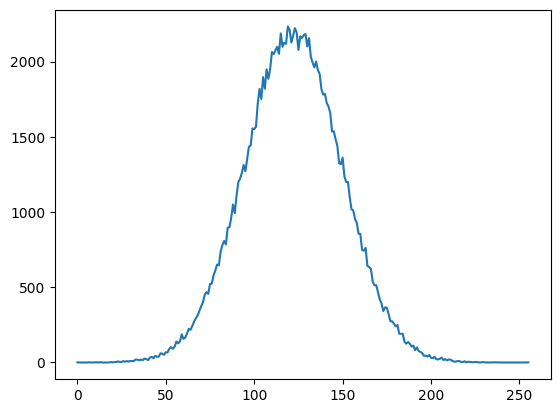

In [50]:
# Take the first tensor and prep the symbols
inp = all_tensors[2]

# get a histogram of the tensor
n_buckets = 2**8
hist, bin_edges = np.histogram(inp.flat, bins=n_buckets)

# plot the histogram
import matplotlib.pyplot as plt
plt.plot(hist)
plt.show()

In [51]:
# Create symbol table with equal distribution
n_symbols = 2**8

sym_table = np.linspace(min(inp.flat), max(inp.flat), n_symbols)
sym_table = np.column_stack((sym_table,hist))

In [52]:
sym_table

array([[-4.47050238e+00,  1.00000000e+00],
       [-4.43382203e+00,  0.00000000e+00],
       [-4.39714168e+00,  0.00000000e+00],
       [-4.36046134e+00,  0.00000000e+00],
       [-4.32378099e+00,  0.00000000e+00],
       [-4.28710064e+00,  0.00000000e+00],
       [-4.25042030e+00,  0.00000000e+00],
       [-4.21373995e+00,  1.00000000e+00],
       [-4.17705960e+00,  0.00000000e+00],
       [-4.14037925e+00,  0.00000000e+00],
       [-4.10369891e+00,  1.00000000e+00],
       [-4.06701856e+00,  1.00000000e+00],
       [-4.03033821e+00,  0.00000000e+00],
       [-3.99365787e+00,  2.00000000e+00],
       [-3.95697752e+00,  0.00000000e+00],
       [-3.92029717e+00,  0.00000000e+00],
       [-3.88361683e+00,  0.00000000e+00],
       [-3.84693648e+00,  0.00000000e+00],
       [-3.81025613e+00,  1.00000000e+00],
       [-3.77357579e+00,  2.00000000e+00],
       [-3.73689544e+00,  1.00000000e+00],
       [-3.70021509e+00,  2.00000000e+00],
       [-3.66353475e+00,  4.00000000e+00],
       [-3.

In [53]:
from scipy.stats import entropy
# calculate current size of table using entropy
def calculate_entropy(data):
    """
    Calculate the entropy of a dataset.
    
    Parameters:
        data (list or np.array or pd.Series): The input data (categorical or discrete values).
    
    Returns:
        float: The calculated entropy.
    """
    if isinstance(data, pd.Series):
        value_counts = data.value_counts(normalize=True)
    else:
        value_counts = pd.Series(data).value_counts(normalize=True)
    
    return entropy(value_counts)

In [54]:
# go through each bin, and calculate the entropy
entropies = []
for i in range(n_buckets):
    # get the indices of the data that are in the bin
    indices = np.where((inp.flat >= bin_edges[i]) & (inp.flat < bin_edges[i+1]))[0]
    
    # calculate the entropy of the data in the bin
    entropies.append(calculate_entropy(inp.flat[indices]))

In [55]:
sum(entropies)/(2**8)

4.3160160143724955

In [56]:
len(entropies)

256